In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost

In [2]:
df = pd.read_excel('Customer Churn.xlsx')
# transform the column names to be able to use dot notation as well as bracket notation
df.columns = [x.replace(' ', '_').lower() for x in df.columns]
pd.set_option('display.max_columns', len(df.columns)) #to show all columns of the dataset
df.sample(5)

,customerid,count,country,state,city,zip_code,lat_long,latitude,longitude,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn_label,churn_reason
4860,7980-MHFLQ,1,United States,California,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Female,No,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,24.90,1859.2,No,NaN
2865,7722-VJRQD,1,United States,California,Brooks,95606,"38.809804, -122.241383",38.809804,-122.241383,Male,No,Yes,No,72,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),60.95,4549.05,No,NaN
4104,1796-JANOW,1,United States,California,Fiddletown,95629,"38.513484, -120.704613",38.513484,-120.704613,Female,No,No,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.95,38.15,No,NaN
3896,2323-ARSVR,1,United States,California,Milpitas,95035,"37.441931, -121.878502",37.441931,-121.878502,Male,No,Yes,No,67,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,111.05,7321.05,No,NaN
913,7730-IUTDZ,1,United States,California,Chatsworth,91311,"34.294142, -118.603883",34.294142,-118.603883,Male,No,No,No,43,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.20,3198.6,Yes,Network reliability


In [3]:
df.describe()

,count,zip_code,latitude,longitude,tenure_months,monthly_charges
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000


In [4]:
df.describe(include='O')

,customerid,country,state,city,lat_long,gender,senior_citizen,partner,dependents,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,total_charges,churn_label,churn_reason
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.0,7043,1869
unique,7043,1,1,1129,1652,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531.0,2,20
top,3668-QPYBK,United States,California,Los Angeles,"33.964131, -118.272783",Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No,Attitude of support person
freq,1,7043,7043,305,5,3555,5901,3641,5416,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11.0,5174,192


In [5]:
# total_charges should be transformed into numeric, but before we should replace entries of ' ' with np.nan ones
df['total_charges'] = df['total_charges'].replace(' ', np.nan).astype(float)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         7043 non-null   object 
 1   count              7043 non-null   int64  
 2   country            7043 non-null   object 
 3   state              7043 non-null   object 
 4   city               7043 non-null   object 
 5   zip_code           7043 non-null   int64  
 6   lat_long           7043 non-null   object 
 7   latitude           7043 non-null   float64
 8   longitude          7043 non-null   float64
 9   gender             7043 non-null   object 
 10  senior_citizen     7043 non-null   object 
 11  partner            7043 non-null   object 
 12  dependents         7043 non-null   object 
 13  tenure_months      7043 non-null   int64  
 14  phone_service      7043 non-null   object 
 15  multiple_lines     7043 non-null   object 
 16  internet_service   7043 

In [7]:
df.duplicated().sum()

0

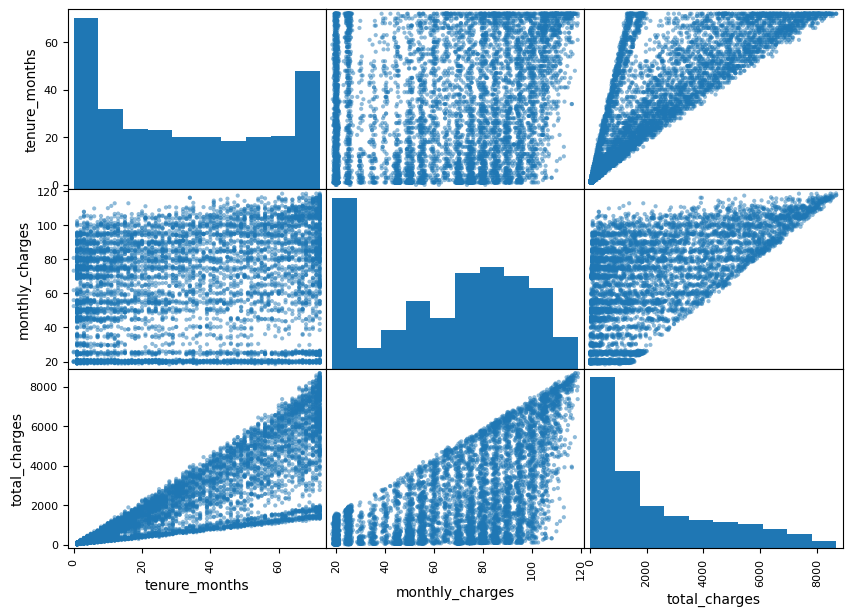

In [8]:
_ = pd.plotting.scatter_matrix(df[['tenure_months', 'monthly_charges', 'total_charges']], figsize=(10, 7))

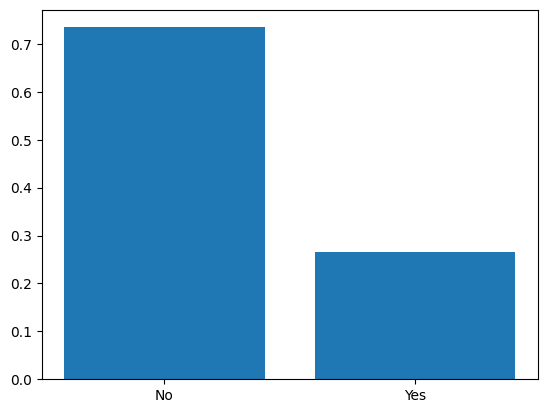

In [9]:
# the data is imbalanced, as we have 27% of churned customers
# however 27% is a very high number for a company
_ = plt.bar(x = df['churn_label'].value_counts(normalize=True).index, 
        height = df['churn_label'].value_counts(normalize=True))
plt.show()

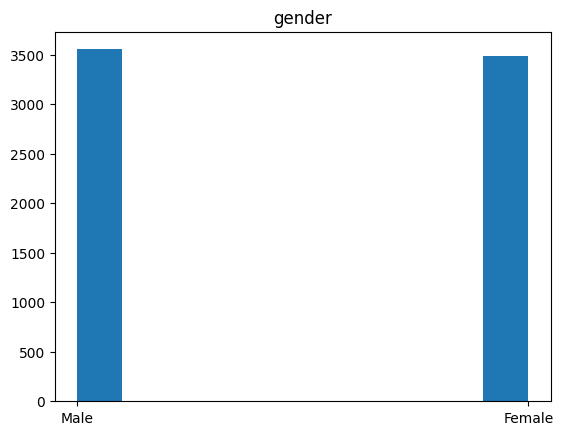

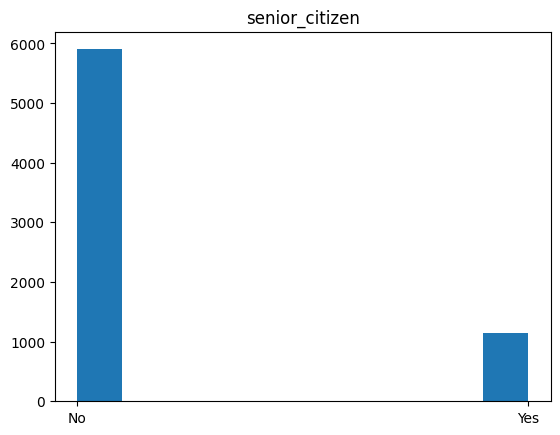

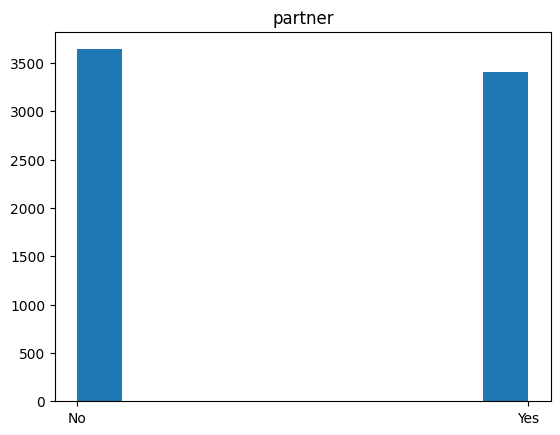

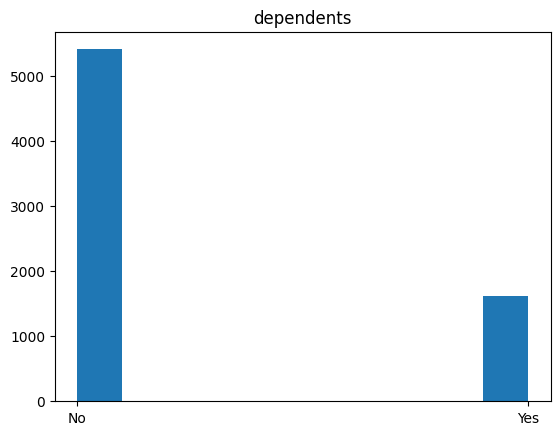

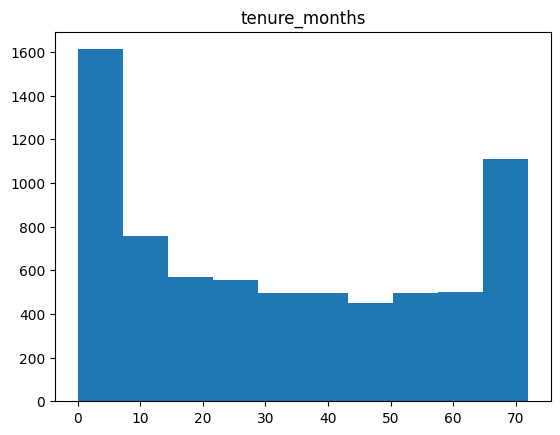

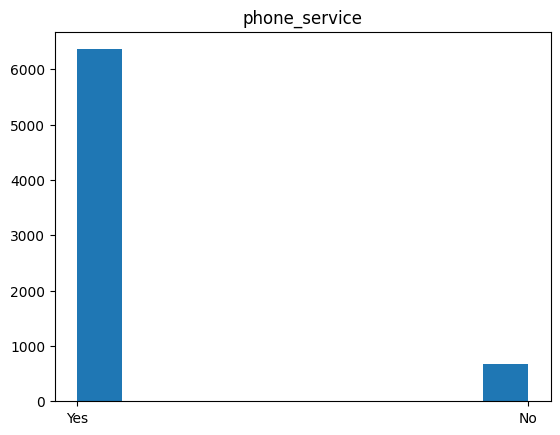

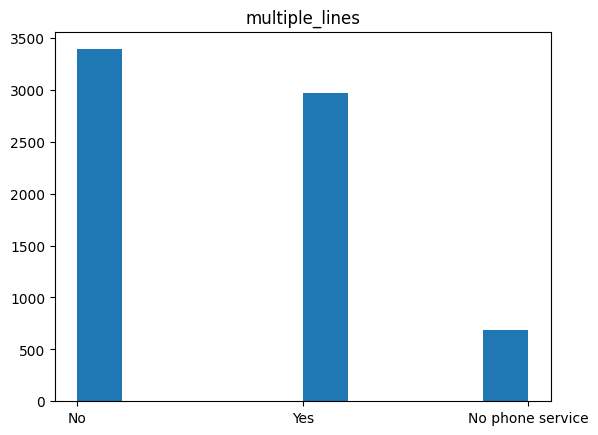

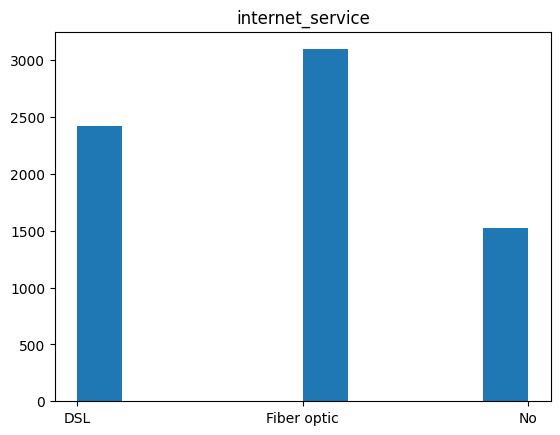

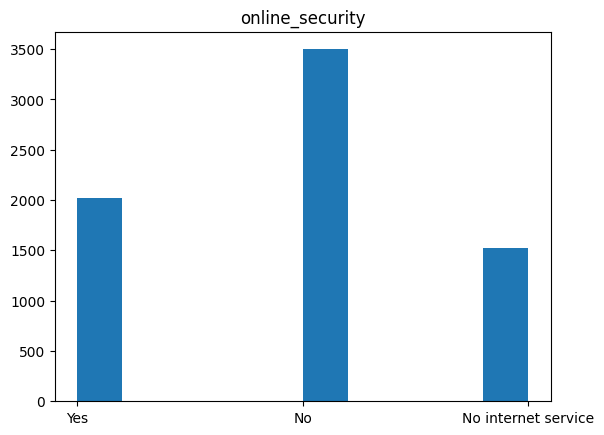

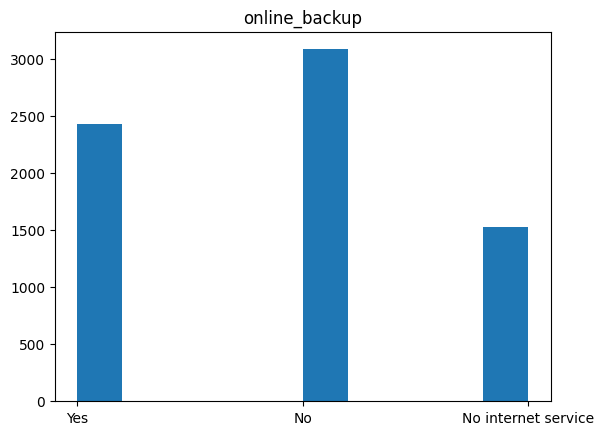

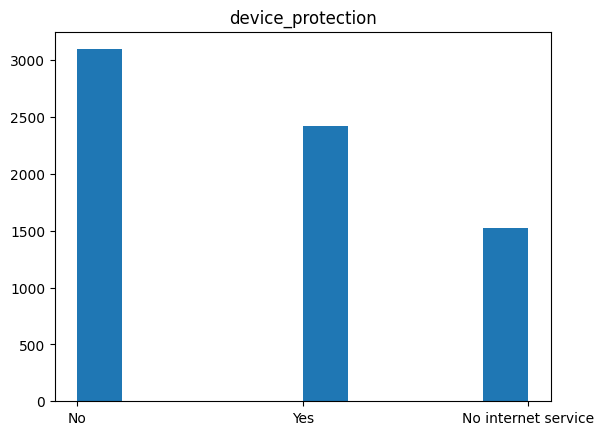

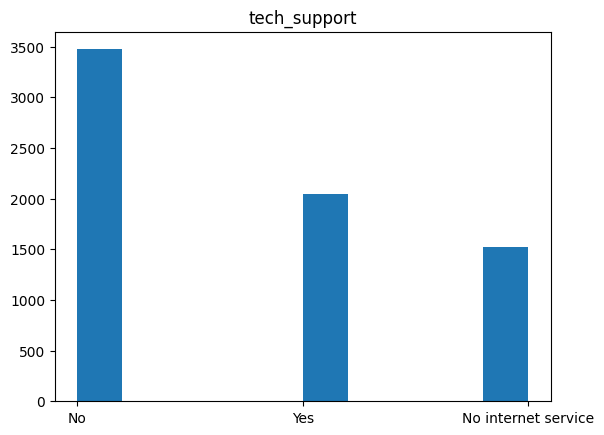

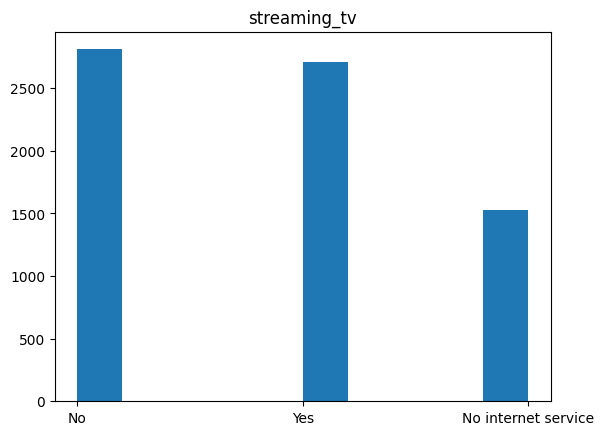

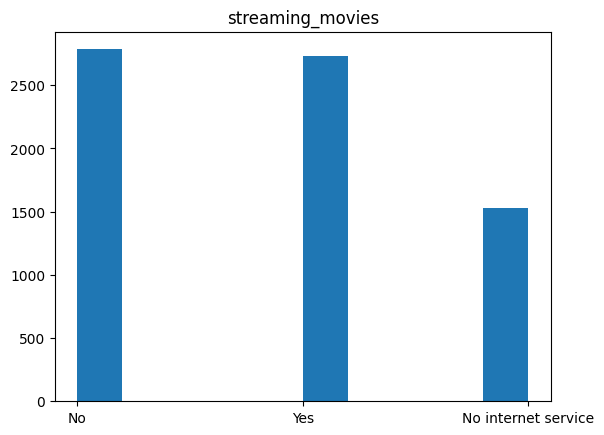

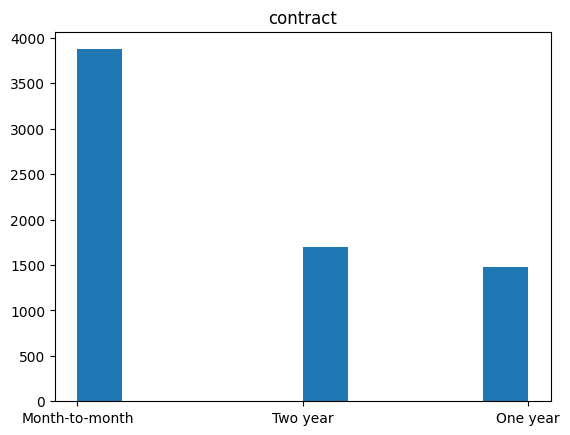

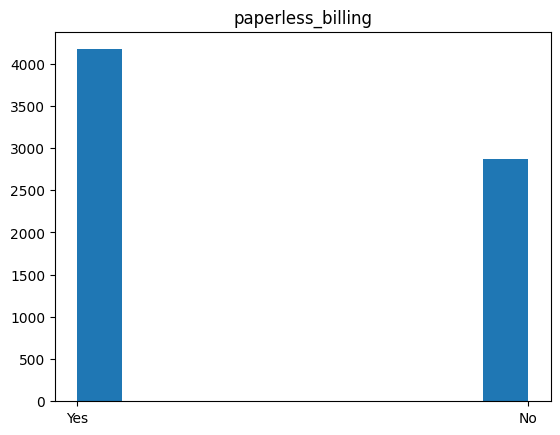

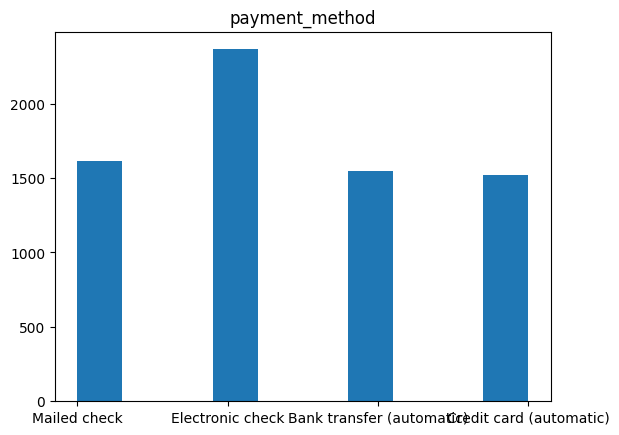

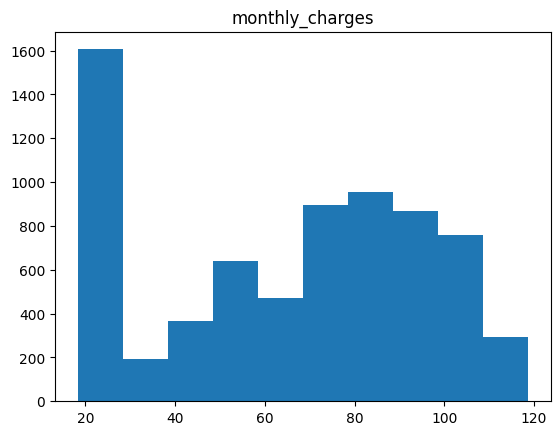

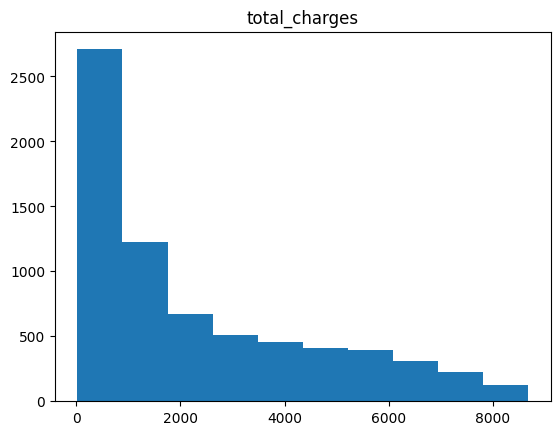

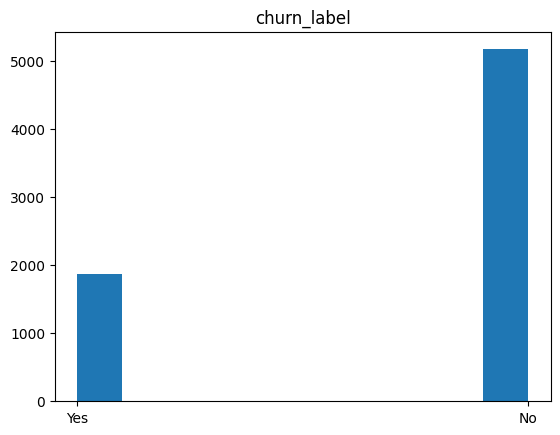

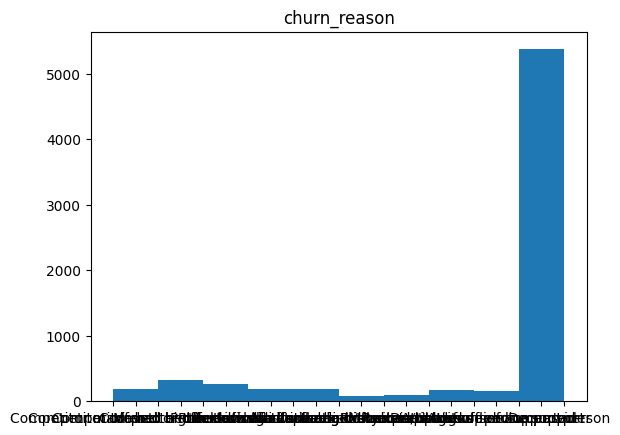

In [10]:
# Let's have a look at all features histograms with 
col_hist = df.columns[~df.columns.isin(['customerid', 'count', 'country', 'state', 'zip_code',
                                        'lat_long', 'latitude', 'longitude', 'city'])]
df['churn_reason'] = df['churn_reason'].fillna('')

for i in col_hist:
    _ = plt.hist(df[i])
    plt.title(i)
    plt.show()

when it comes to features, most are binary: 
<li> gender, 
<li> senior_citizen, 
<li> partner, 
<li> dependents, 
<li> phone_service, 
<li> paperless_billing
<br> Target variable (churn_value) is also binary

##### Are there outliers in data?

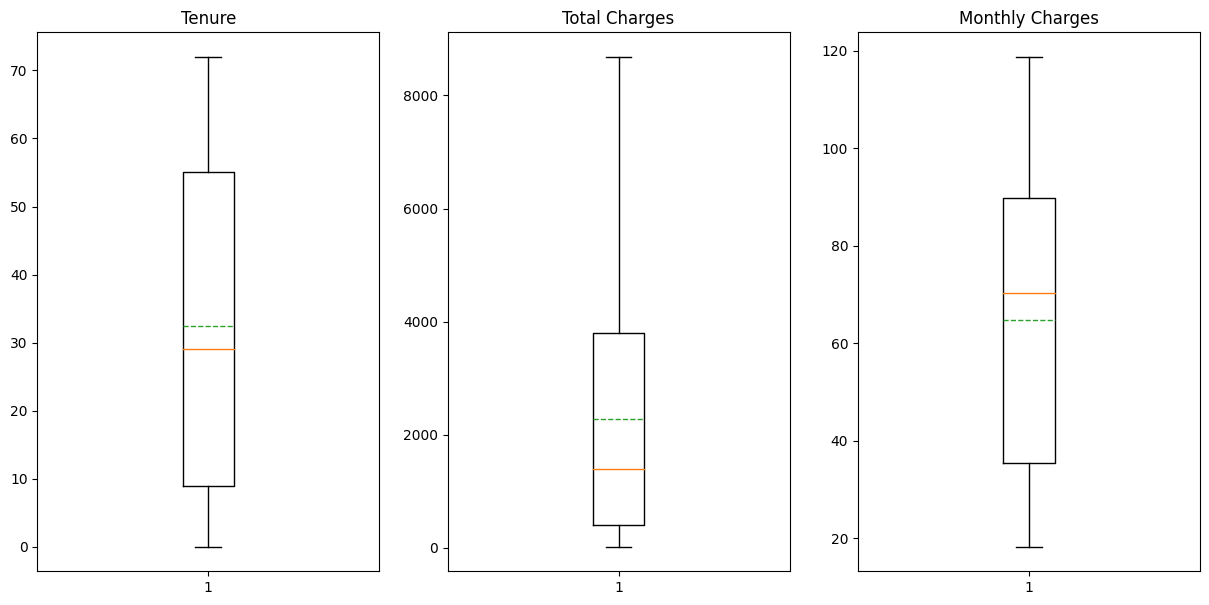

In [11]:
#'monthly_charges', 'total_charges', 'tenure_months'
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].boxplot(df['tenure_months'], showmeans=True, meanline=True)
axes[1].boxplot(df['total_charges'].dropna(), showmeans=True, meanline=True)
axes[2].boxplot(df['monthly_charges'], showmeans=True, meanline=True)
axes[0].set_title('Tenure')
axes[1].set_title('Total Charges')
axes[2].set_title('Monthly Charges')
plt.show()

There are no outliers in data, but the distributon is skewed (left-skewed for tenure and total charges as median is lower than average and right-skewed for monthly charges)

#### Correlation matrix for numeric vars

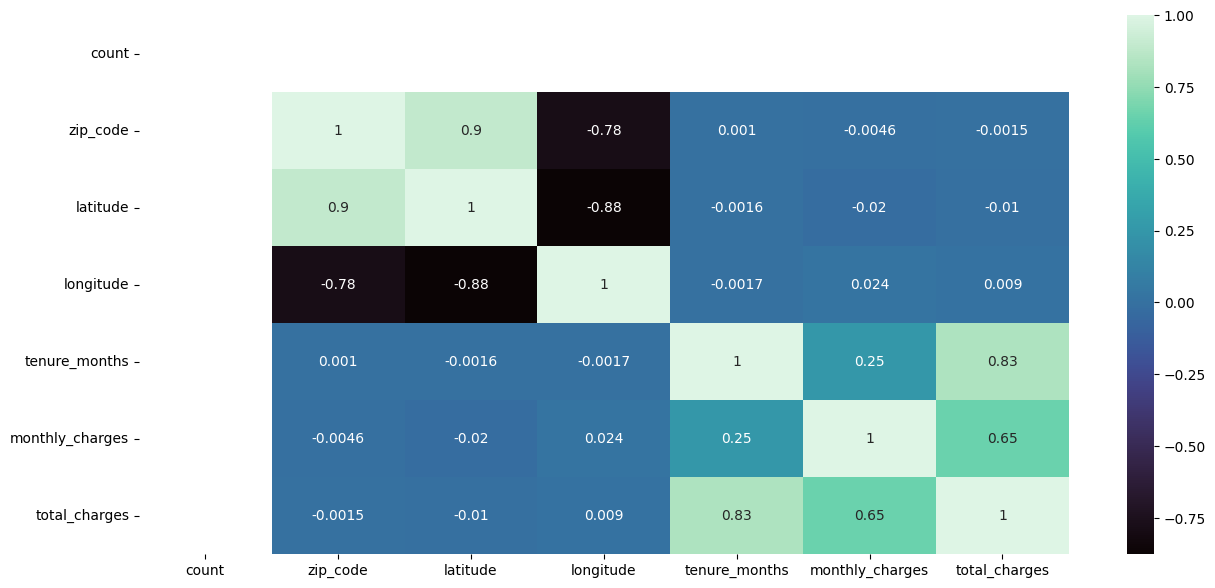

In [12]:
plt.figure(figsize=(15, 7))
_ = sns.heatmap(df.corr('pearson', numeric_only=True), cmap='mako', annot=True)
plt.show()

There is strong correlation between the tenure and total charges, which is completely logical, as the longer customers stays - the more money they bring
<br><br>
##### Is it different for loyal customers and those who churned?

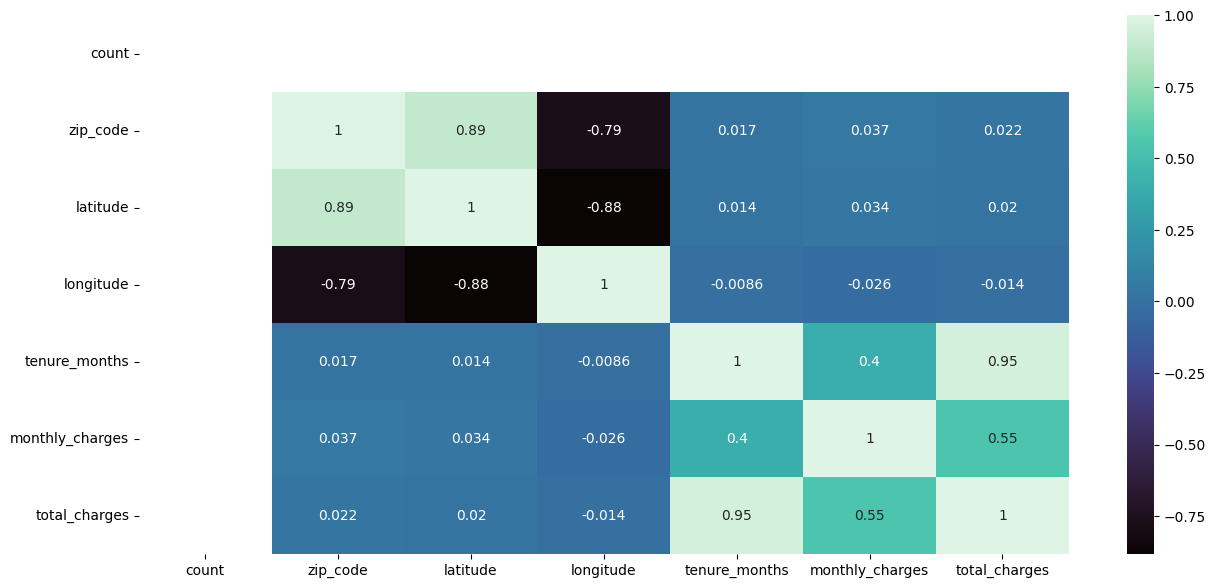

In [13]:
plt.figure(figsize=(15, 7))
_ = sns.heatmap(df[df.churn_label=='Yes'].corr('pearson', numeric_only=True), cmap='mako', annot=True)
plt.show()

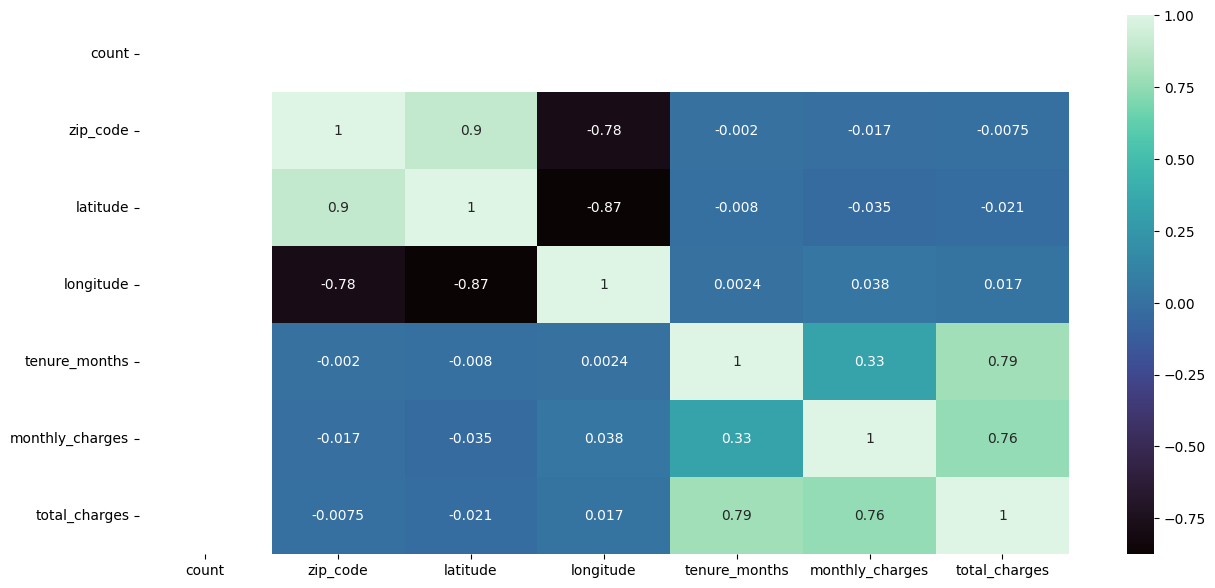

In [14]:
plt.figure(figsize=(15, 7))
_ = sns.heatmap(df[df.churn_label=='No'].corr('pearson', numeric_only=True), cmap='mako', annot=True)
plt.show()

The interesting thing is that correlation between monthly charges and tenure is higher for churned customers
<br><br>
Additional data could help us answer the question why, as we will be able to undertstand the loyal and churned customers better. For example, 
<li> does offering a discount or conducting a promotional campaign helps our customers to stay loyal? 
<li> how old are the customers, as older customers might be more loyal and younger ones need additional motivation to stay loyal. Other demographics data can also be useful
<br> etc.

In [15]:
temp1 = df[['total_charges', 'tenure_months', 'churn_label']].copy()
temp2 = df[['monthly_charges', 'tenure_months', 'churn_label']].copy()

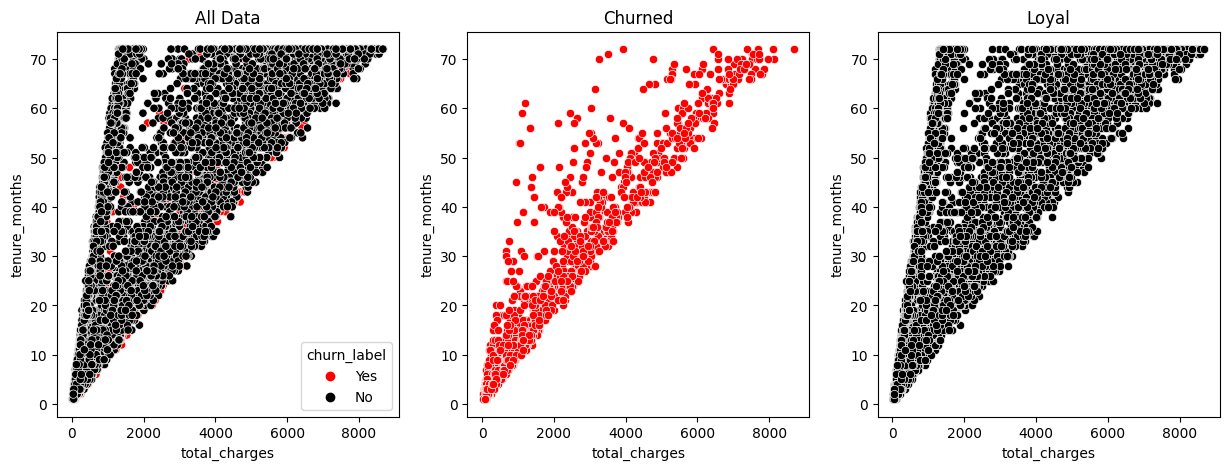

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = sns.scatterplot(ax=axes[0], x='total_charges', y='tenure_months', data=temp1, 
                    hue='churn_label', palette={'Yes': 'Red', 'No': 'Black'})
_ = sns.scatterplot(ax=axes[1], x='total_charges', y='tenure_months', 
                    data=temp1[temp1.churn_label=='Yes'], c='Red')
_ = sns.scatterplot(ax=axes[2], x='total_charges', y='tenure_months', 
                    data=temp1[temp1.churn_label=='No'], c='Black')
axes[0].set_title('All Data')
axes[1].set_title('Churned')
axes[2].set_title('Loyal')
plt.show()

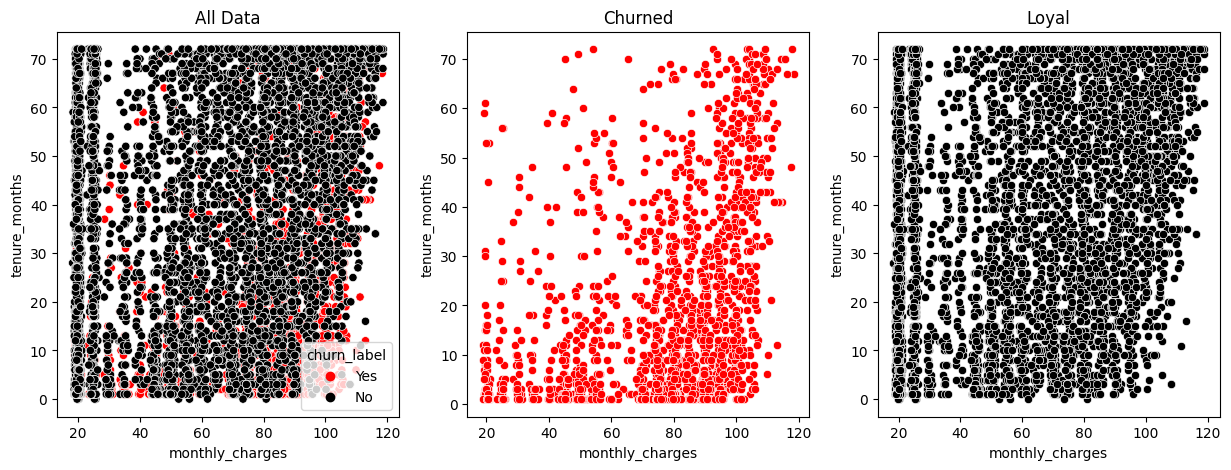

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = sns.scatterplot(ax=axes[0], x='monthly_charges', y='tenure_months', data=temp2, 
                    hue='churn_label', palette={'Yes': 'Red', 'No': 'Black'})
_ = sns.scatterplot(ax=axes[1], x='monthly_charges', y='tenure_months', 
                    data=temp2[temp2.churn_label=='Yes'], c='Red')
_ = sns.scatterplot(ax=axes[2], x='monthly_charges', y='tenure_months', 
                    data=temp2[temp2.churn_label=='No'], c='Black')
axes[0].set_title('All Data')
axes[1].set_title('Churned')
axes[2].set_title('Loyal')
plt.show()

Let's see how different features are influencing customers and try to find interesting relations

#### Demographics: 
<li> 'gender',
<li> 'senior_citizen', 
<li> 'partner', 
<li> 'dependents'

In [18]:
def countplot_churn(df, col, axis):
    """To follow DRY method, let's use a function to build countplots to look into the data """
    _ = sns.countplot(ax=axis, x=col, hue='churn_label', data=df, palette={'Yes': 'Red', 'No': 'Black'})
    return _

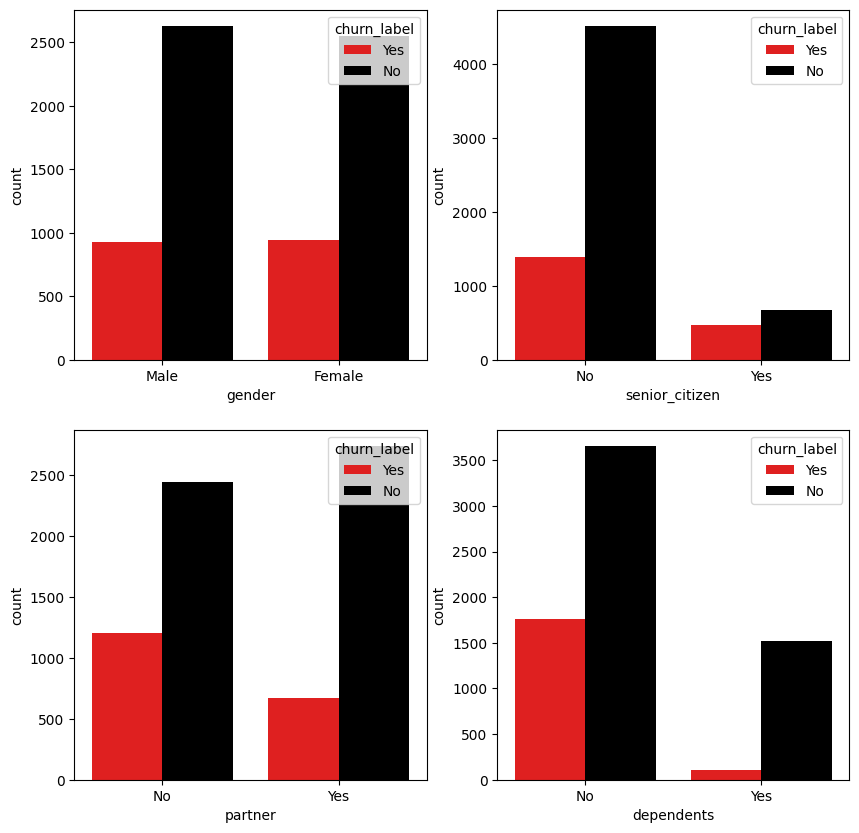

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
demo_cols = df.columns[9:13]
counter = 0
for i in range(len(axes[0])):
    for j in range(len(axes[1])):
        _ = countplot_churn(df, demo_cols[counter], axes[i,j])
        counter+=1

Interestingly, customers with no partner and/or dependents tend to churn more frequently
<br><br>
Let's have a closer look at these two features

In [20]:
pd.crosstab(df['partner'].map({'Yes': False, 'No': True}) & df['dependents'].map({'Yes': False, 'No': True})
            , df['churn_label'])

churn_label,No,Yes
row_0,,
False,2985,719
True,2189,1150


Out of all churned customers a lot - **61.5%** - are having neither partner nor dependents 

#### Services: 
<li> 'phone_service',
<li> 'multiple_lines', 
<li> 'internet_service', 
<li> 'online_security',
<li> 'online_backup',
<li> 'device_protection', 
<li> 'tech_support', 
<li> 'streaming_tv',
<li> 'streaming_movies'

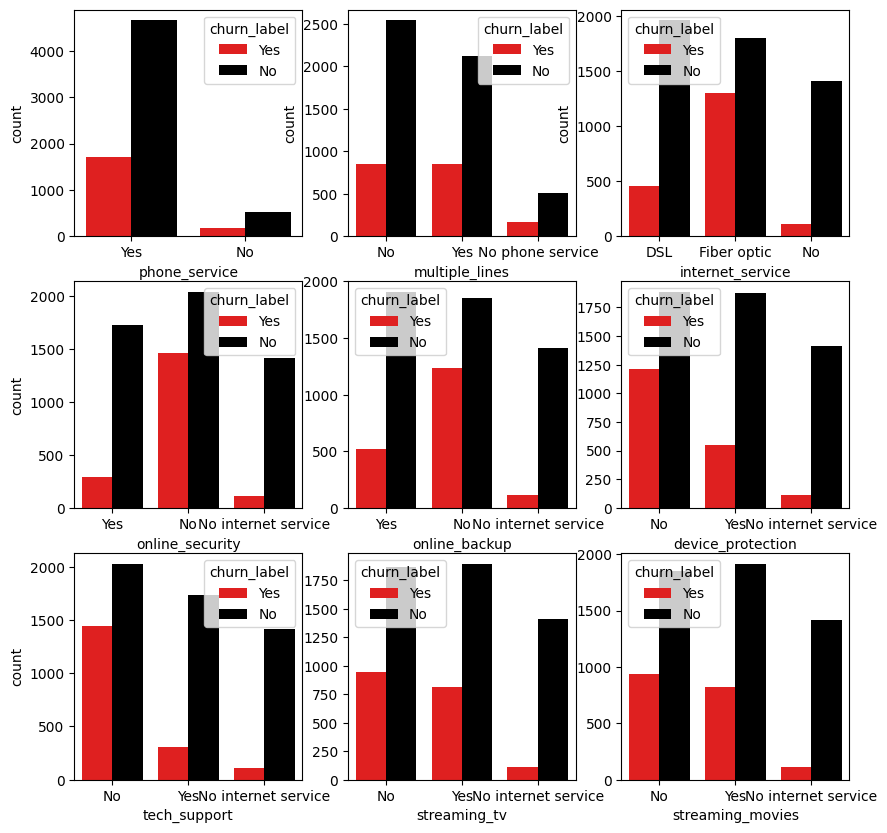

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
services_cols = df.columns[14:23]
counter = 0
for i in range(len(axes[0])):
    for j in range(len(axes[1])):
        _ = countplot_churn(df, services_cols[counter], axes[i,j])
        counter+=1

Customers with fiber optic tend to churn more frequently than customers with DSL or no internet service at all.
<br>
Customers with no online security tend to churn more frequently than other customers. As well as customers with no online backup, no device protection, and no technical support. 
<br>
As for steaming services, there is no significant difference.

#### Contract & billing
<li> 'contract',
<li> 'paperless_billing', 
<li> 'payment_method'

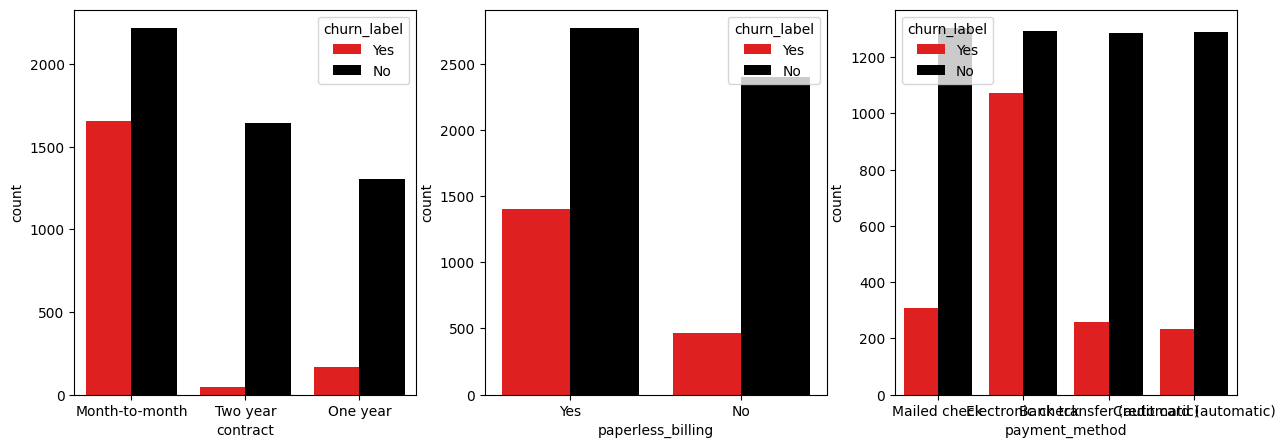

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
c_b_cols = df.columns[-7:-4]
counter = 0
for i in range(len(axes)):
        _ = countplot_churn(df, c_b_cols[counter], axes[i])
        counter+=1

Customers with `month-to_month contract` tend to churn far more frequently than the rest of customers. 
Same applies to customers with `electronic check` type of payment, while others tend to churn less.

### Geo location & Churn

#### Assumption 1: Geographic location of the customer matters

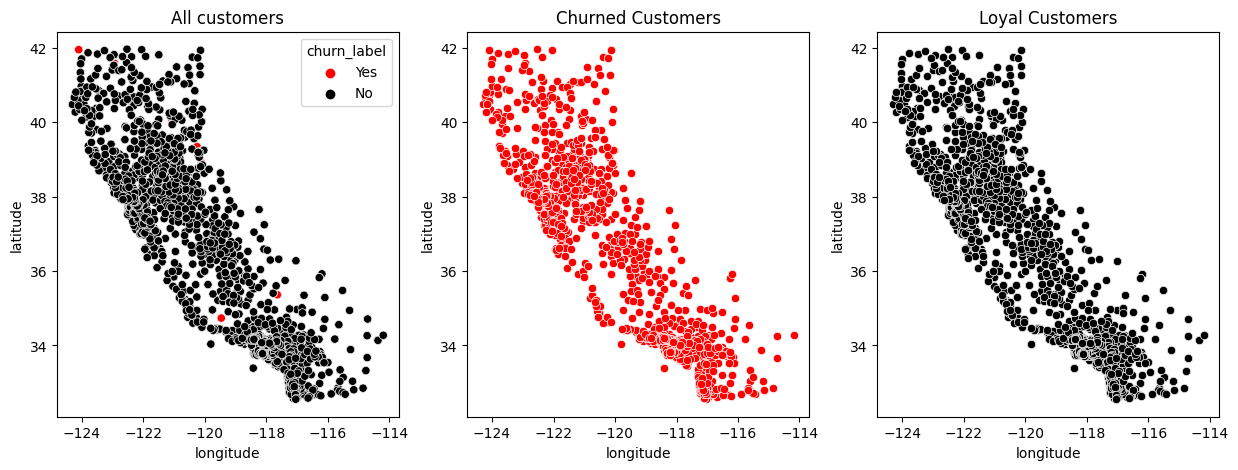

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = sns.scatterplot(ax=axes[0], x='longitude', y='latitude', data=df, hue='churn_label', 
                    palette={'Yes': 'Red', 'No': 'Black'})
_ = sns.scatterplot(ax=axes[1], x='longitude', y='latitude', data=df[df['churn_label']=='Yes'], color='Red')
_ = sns.scatterplot(ax=axes[2], x='longitude', y='latitude', data=df[df['churn_label']=='No'], color='Black')
axes[0].set_title('All customers')
axes[1].set_title('Churned Customers')
axes[2].set_title('Loyal Customers')
plt.show()

There is no clusters of churns attributed to specific geographic locations

#### Assumption 2: Geographic location for churned customers is linked to churn reasons

In [24]:
df[df['churn_label']=='Yes']['churn_reason'].value_counts(normalize=True)

Attitude of support person                   0.102729
Competitor offered higher download speeds    0.101124
Competitor offered more data                 0.086677
Don't know                                   0.082397
Competitor made better offer                 0.074906
Attitude of service provider                 0.072231
Competitor had better devices                0.069556
Network reliability                          0.055110
Product dissatisfaction                      0.054575
Price too high                               0.052434
Service dissatisfaction                      0.047619
Lack of self-service on Website              0.047084
Extra data charges                           0.030498
Moved                                        0.028357
Limited range of services                    0.023542
Long distance charges                        0.023542
Lack of affordable download/upload speed     0.023542
Poor expertise of phone support              0.010701
Poor expertise of online sup

The main churn reasons are the dissatisfactory support service (Attitude of support person, Attitude of service provider) and competitors offers (Competitor offered higher download speeds, Competitor offered more data, Competitor made better offer) <br><br>
Do the competitors operate in certain regions? <br>
Do the customers of a certain region have more dissatisfaction with support?

In [25]:
competitors = [i for i in df.churn_reason.unique() if 'Competitor' in i]
support = [i for i in df.churn_reason.unique() if 'support' in i]

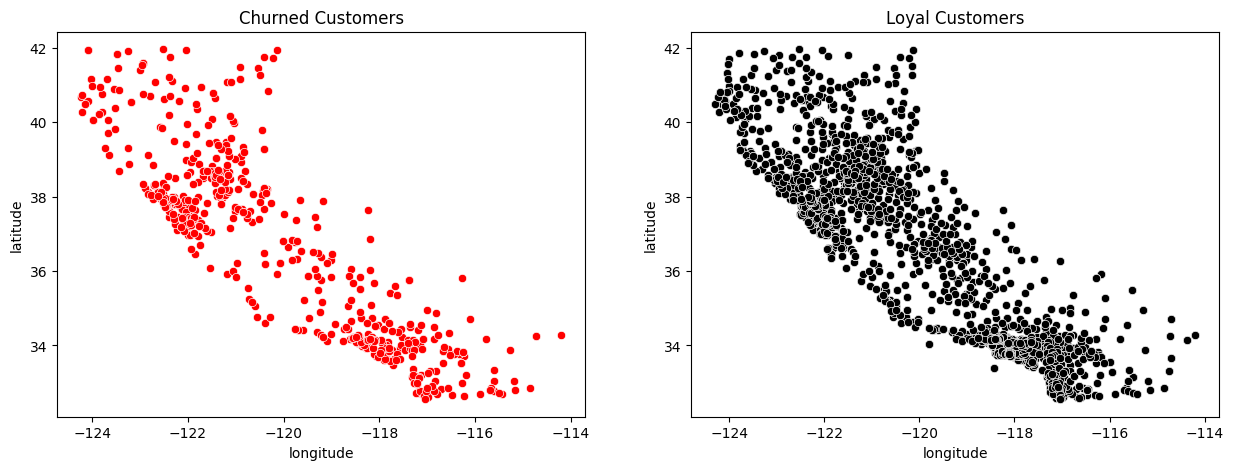

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
_ = sns.scatterplot(ax=axes[0], x='longitude', y='latitude', color='Red',
                    data=df[(df['churn_label']=='Yes') & (df.churn_reason.isin(competitors))])
_ = sns.scatterplot(ax=axes[1], x='longitude', y='latitude', color='Black', data=df[df['churn_label']=='No'])
axes[0].set_title('Churned Customers')
axes[1].set_title('Loyal Customers')
plt.show()

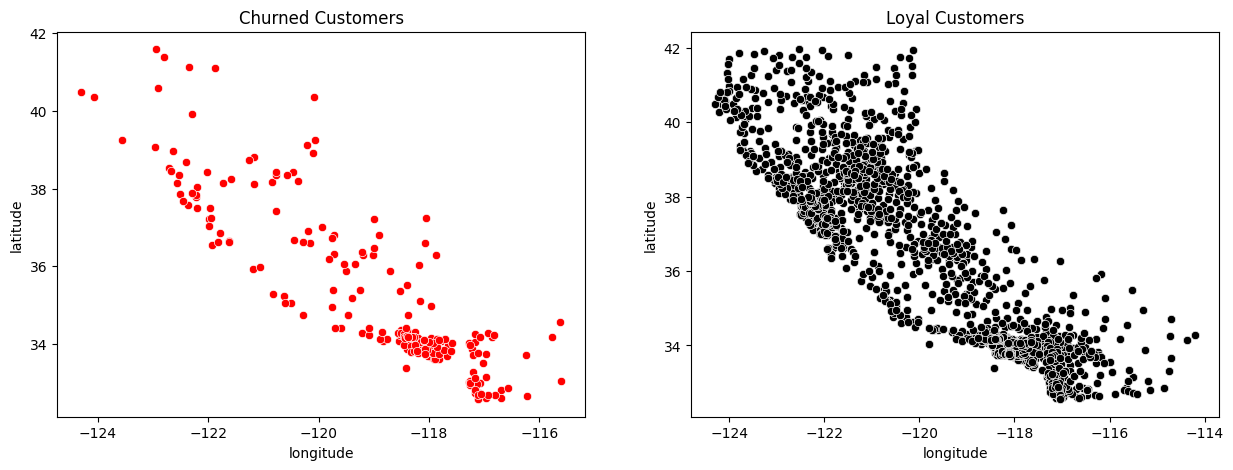

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
_ = sns.scatterplot(ax=axes[0], x='longitude', y='latitude', color='Red',
                    data=df[(df['churn_label']=='Yes') & (df.churn_reason.isin(support))])
_ = sns.scatterplot(ax=axes[1], x='longitude', y='latitude', color='Black', data=df[df['churn_label']=='No'])
axes[0].set_title('Churned Customers')
axes[1].set_title('Loyal Customers')
plt.show()

Customers that try to reach support in Los Angeles, San Diego, and area nearby have more dissatisfacction because of customer support. So it makes sense to look into customer support logs to better understand the reasons behind customer dissatisfaction.

Last but not least, let's transform dataset and look into correlations for all features

In [28]:
cust_id = df.customerid
city = df.city
df.drop(['customerid', 'count', 'country', 'state', 'lat_long', 'city'], axis=1, inplace=True)
df['churn_label'] = df['churn_label'].map({'Yes': 1, 'No': 0})
df_final = pd.get_dummies(df)

<AxesSubplot: >

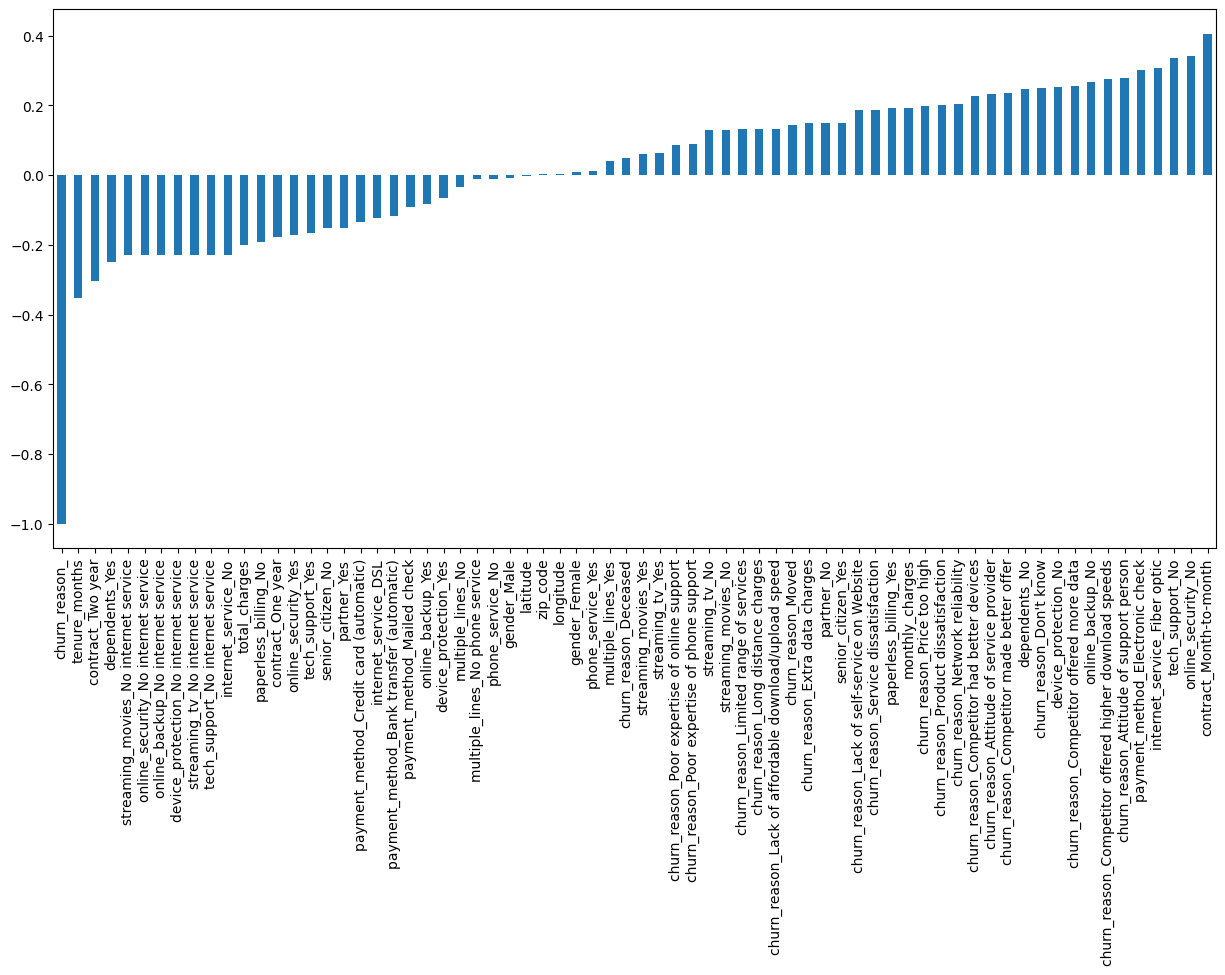

In [29]:
plt.figure(figsize=(15, 7))
df_final.corr().drop('churn_label')['churn_label'].sort_values().plot(kind='bar')

We can see positive correlations with monthly contracts, no online security and tech support, as well as with fiber optic and electronic check.
<br>
As for negative correlations, the strongest are the tenure, two year contracts, and dependents.

### Models & Evaluation
<br>

Since the shape of data is relatively small, we can try to use different models, measure their performance and choose the best one. 
<li> Logistic regression: the simplest algorithm for binary classification problems. In this case we can also predict the probabilities, which can then be brought to stakeholders to define the right threshold and not spend more money than necessary.
<li> Decision Trees: it can be easily interpreted and explained to business audience
<li> Random forest: it's a very robust to overfitting model, also it work quite fast as trees are built in parralel to each other
<li> Gradient boosting: it can be very accurate and works good on smaller datasets

<br><br> Among the most common metric for model performance evaluation in churn prediction tasks are the following:
<li> Accuracy: can't be used in our case, as our dataset is imbalanced
<li> Precision
<li> Recall
<li> F1 Score <br>
The precision and recall are very useful in this case, as they'll help identify FP predictions and proportion of correct prediction respectively. F1 score is also very useful in case of imbalanced datasets. <br>
That's why in our case we'll use all three of them to evaluate model performance


In [30]:
churn_reasons_cols = [i for i in df_final.columns if 'churn_reason' in i]
churn_reasons = df_final[churn_reasons_cols]
df_final.drop(churn_reasons_cols, axis=1, inplace=True)
df_final.dropna(inplace=True)

#### Logistic regression

In [31]:
y, x = df_final.churn_label, df_final.drop('churn_label', axis=1)
#scaling features
features = x.columns
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x))
x.columns = features

#splitting data into tran and test (20-80 split)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)

In [32]:
lr_model = LogisticRegression(random_state=777, max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=777)

In [33]:
y_pred_lr = lr_model.predict(X_test)
print('precision: ', round(precision_score(y_test, y_pred_lr), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_lr), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_lr), 2), '\n')

precision:  0.68 
 recall:  0.59 
 F1:  0.63 



In [34]:
accuracy_score(y_test, y_pred_lr)

0.8102345415778252

The scores for this model are quite low, despite the high accuracy score (that's why we shouldn't use it for imbalanced datasets). To improve we can look further into parameters and find the best combination or we can llok into feature importance and remove the ones, that might negatively influence the model performance or perform feature engineering and/or additional data collection <br>
However, let's try to look into different models

#### Decision Trees

In [35]:
tree = DecisionTreeClassifier(random_state=777, max_depth=5, criterion='entropy')
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print('precision: ', round(precision_score(y_test, y_pred_tree), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_tree), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_tree), 2), '\n')

precision:  0.62 
 recall:  0.65 
 F1:  0.64 



In [36]:
accuracy_score(y_test, y_pred_tree)

0.7960199004975125

In [37]:
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=777), 
                         {'criterion': ['gini', 'entropy', 'log_loss']
                          , 'ccp_alpha': np.linspace(0., 3.1, num=10)
                          , 'max_depth': range(2, 11)})
tree_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=777),
             param_grid={'ccp_alpha': array([0.        , 0.34444444, 0.68888889, 1.03333333, 1.37777778,
       1.72222222, 2.06666667, 2.41111111, 2.75555556, 3.1       ]),
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(2, 11)})

In [38]:
y_pred_tree_grid = tree_grid.predict(X_test)
print('precision: ', round(precision_score(y_test, y_pred_tree_grid), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_tree_grid), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_tree_grid), 2), '\n')

precision:  0.62 
 recall:  0.65 
 F1:  0.64 



In [39]:
accuracy_score(y_test, y_pred_tree_grid)

0.7960199004975125

So far the recall and F1 were improved

#### Random Forest

In [40]:
random_forest = RandomForestClassifier(random_state=777, max_depth=7)
random_forest.fit(X_train, y_train)
y_pred_forest = random_forest.predict(X_test)

print('precision: ', round(precision_score(y_test, y_pred_forest), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_forest), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_forest), 2), '\n')

precision:  0.71 
 recall:  0.57 
 F1:  0.63 



In [41]:
accuracy_score(y_test, y_pred_forest)

0.8180525941719972

#### Gradient Boosting

In [42]:
boosting = xgboost.XGBClassifier(random_state=777)
boosting.fit(X_train, y_train)
y_pred_gb = boosting.predict(X_test)

print('precision: ', round(precision_score(y_test, y_pred_gb), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_gb), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_gb), 2), '\n')

precision:  0.64 
 recall:  0.55 
 F1:  0.59 



In [43]:
accuracy_score(y_test, y_pred_gb)

0.7896233120113717

In [44]:
grid_searcher_boosting = GridSearchCV(xgboost.XGBClassifier(random_state=777), 
                                      {'n_estimators': range(10, 101, 2)
                                       , 'max_depth':  range(2, 11)})
grid_searcher_boosting.fit(X_train, y_train)
y_pred_boosting_grid = grid_searcher_boosting.predict(X_test)

print('precision: ', round(precision_score(y_test, y_pred_boosting_grid), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_boosting_grid), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_boosting_grid), 2), '\n')

precision:  0.67 
 recall:  0.57 
 F1:  0.62 



In [45]:
accuracy_score(y_test, y_pred_boosting_grid)

0.8052594171997157

In [46]:
results = pd.DataFrame(columns=['model', 'precision', 'recall', 'F1', 'accuracy'])
results['model'] = ['Logistic regression', 'Decision Tree', 'Random forest', 'Gradient boosting', 'Gradient boosting GS']
results['precision'] = [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_tree), 
                        precision_score(y_test, y_pred_forest), precision_score(y_test, y_pred_gb),
                        precision_score(y_test, y_pred_boosting_grid)]
results['recall'] = [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_tree), 
                     recall_score(y_test, y_pred_forest), recall_score(y_test, y_pred_gb),
                     recall_score(y_test, y_pred_boosting_grid)]
results['F1'] =  [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_tree), 
                  f1_score(y_test, y_pred_forest), f1_score(y_test, y_pred_gb),
                  f1_score(y_test, y_pred_boosting_grid)]
results['accuracy'] =  [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_tree), 
                        accuracy_score(y_test, y_pred_forest), accuracy_score(y_test, y_pred_gb),
                        accuracy_score(y_test, y_pred_boosting_grid)]
results

,model,precision,recall,F1,accuracy
0,Logistic regression,0.678571,0.589147,0.630705,0.810235
1,Decision Tree,0.623153,0.653747,0.638083,0.796020
2,Random forest,0.710611,0.571059,0.633238,0.818053
3,Gradient boosting,0.636637,0.547804,0.588889,0.789623
4,Gradient boosting GS,0.672783,0.568475,0.616246,0.805259


Depending on the main metric or weighted metrics results we can choose the best model for predicting churn

If the most important thing is to make `fewer false positive predictions`, then the main metric should be `precision` and the best model is **Random Forest** <br>
If the most important thing is to correctly `identify more of the churned customers`, then the main metric should be `recall` and the best model is **Decision Tree** <br>
If both cases are very important, then the main metric should be `F1` and the best model is **Decision Tree**
<br><br>
To further improve models before putting them into production the following steps could be done:
<li> Re-evaluate all features and remove the ones, that might decrease the model performance
<li> Investigate better parameters for each model
<li> Engineer new features
<li> Collect more data
<li> Predict probabilities and decide with business audience on the threshold

### Removing features 

We will look into two types of models, the ones, that had the best results for our case: random forest & decision trees

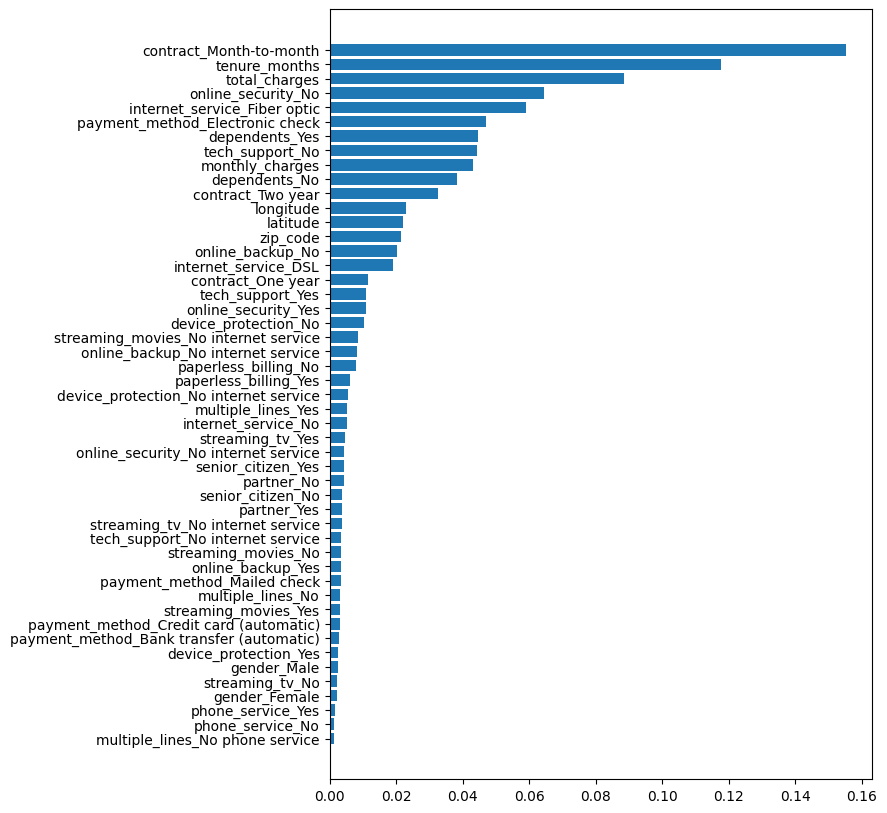

In [47]:
rf_features = pd.DataFrame(dict(zip(X_train.columns, random_forest.feature_importances_)).items())
rf_features.sort_values(1, inplace=True)

plt.figure(figsize=(7, 10))
_ = plt.barh(y=rf_features[0], width= rf_features[1])

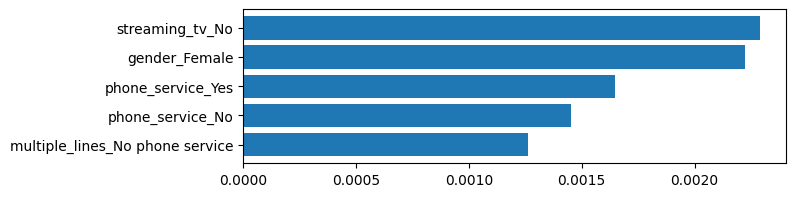

In [48]:
plt.figure(figsize=(7, 2))
_ = plt.barh(y=rf_features[0].head(5), width= rf_features[1].head(5))

In [49]:
rf_features[rf_features[0].str.contains('multiple')]

,0,1
17,multiple_lines_No phone service,0.001261
16,multiple_lines_No,0.003249
18,multiple_lines_Yes,0.005379


In [50]:
rf_features[rf_features[0].str.contains('phone_service')]

,0,1
14,phone_service_No,0.001454
15,phone_service_Yes,0.001649


In [51]:
rf_features[rf_features[0].str.contains('gender')]

,0,1
6,gender_Female,0.002224
7,gender_Male,0.002402


In [52]:
rf_features[rf_features[0].str.contains('streaming')]

,0,1
34,streaming_tv_No,0.002290
39,streaming_movies_Yes,0.003094
37,streaming_movies_No,0.003522
35,streaming_tv_No internet service,0.003675
36,streaming_tv_Yes,0.004507
38,streaming_movies_No internet service,0.008415


In [53]:
features_to_delete_forest = rf_features[rf_features[0].str.contains('streaming|gender|phone_service|multiple'
                                                                    , regex=True)][0].values
X_train_forest = X_train.drop(features_to_delete_forest, axis=1)
X_test_forest = X_test.drop(features_to_delete_forest, axis=1)

In [54]:
random_forest_v2 = RandomForestClassifier(random_state=777, max_depth=7, criterion='log_loss'
                                          , max_features='sqrt')
random_forest_v2.fit(X_train_forest, y_train)
y_pred_forest_v2 = random_forest_v2.predict(X_test_forest)

print('precision: ', round(precision_score(y_test, y_pred_forest_v2), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_forest_v2), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_forest_v2), 2), '\n')

precision:  0.69 
 recall:  0.57 
 F1:  0.62 



In [55]:
accuracy_score(y_test, y_pred_forest_v2)

0.8123667377398721

Let's remove binary features additional columns

In [56]:
binary_features = df.nunique()[df.nunique()==2].index
X_train_bf = X_train.drop(X_train.columns[X_train.columns.str.contains('|'.join(binary_features)
                                                                       , regex=True)][::2], axis=1)
X_test_bf = X_test.drop(X_test.columns[X_test.columns.str.contains('|'.join(binary_features)
                                                                   , regex=True)][::2], axis=1)

wo_binary = [i for i in features_to_delete_forest if i not in 
             X_train.columns[X_train.columns.str.contains('|'.join(binary_features), regex=True)]]
X_train_bf_v2 = X_train_bf.drop(wo_binary, axis=1)
X_test_bf_v2 = X_test_bf.drop(wo_binary, axis=1)

In [57]:
random_forest_v3 = RandomForestClassifier(random_state=777, max_depth=7,  criterion='log_loss'
                                          , max_features='sqrt')
random_forest_v3.fit(X_train_bf, y_train)
y_pred_forest_v3 = random_forest_v3.predict(X_test_bf)

print('precision: ', round(precision_score(y_test, y_pred_forest_v3), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_forest_v3), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_forest_v3), 2), '\n')

precision:  0.71 
 recall:  0.53 
 F1:  0.61 



In [58]:
random_forest_v4 = RandomForestClassifier(random_state=777, max_depth=7,  criterion='entropy'
                                          , max_features='log2')
random_forest_v4.fit(X_train_bf_v2, y_train)
y_pred_forest_v4 = random_forest_v4.predict(X_test_bf_v2)

print('precision: ', round(precision_score(y_test, y_pred_forest_v4), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_forest_v4), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_forest_v4), 2), '\n')

precision:  0.7 
 recall:  0.56 
 F1:  0.62 



### Decision Trees

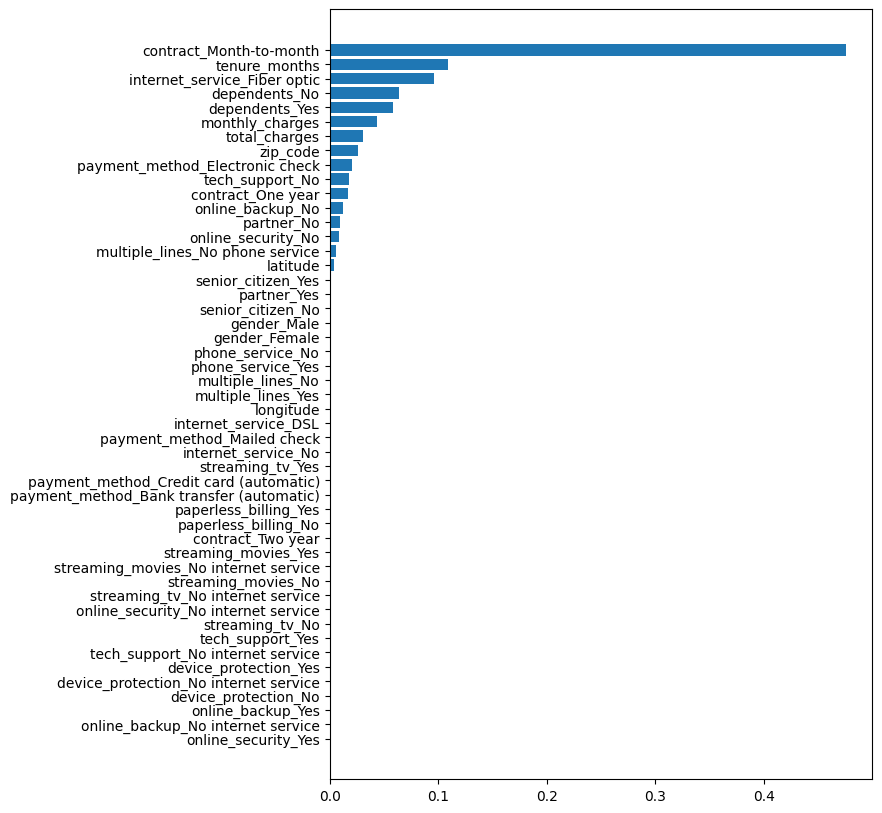

In [59]:
dt_features = pd.DataFrame(dict(zip(X_train.columns, tree.feature_importances_)).items())
dt_features.sort_values(1, inplace=True)

plt.figure(figsize=(7, 10))
_ = plt.barh(y=dt_features[0], width= dt_features[1])

In [60]:
X_train_trees_v2 = X_train[dt_features.tail(6)[0].values].copy()
X_test_trees_v2 = X_test[dt_features.tail(6)[0].values].copy()
X_train_trees_v2 = X_train_trees_v2.drop('dependents_No', axis=1).rename({'dependents_Yes': 'dependents'}, axis=1)
X_test_trees_v2 = X_test_trees_v2.drop('dependents_No', axis=1).rename({'dependents_Yes': 'dependents'}, axis=1)

In [61]:
trees_v2 = DecisionTreeClassifier(random_state=777, max_depth=7, criterion='entropy'
                                  , splitter='random')
trees_v2.fit(X_train_trees_v2, y_train)
y_pred_trees_v2 = trees_v2.predict(X_test_trees_v2)

print('precision: ', round(precision_score(y_test, y_pred_trees_v2), 2), '\n', 
      'recall: ', round(recall_score(y_test, y_pred_trees_v2), 2), '\n',
      'F1: ', round(f1_score(y_test, y_pred_trees_v2), 2), '\n')

precision:  0.68 
 recall:  0.55 
 F1:  0.6 

